In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

In [3]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)


In [4]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [5]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [6]:
#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 20
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
norm_layer = None
print(hidden_size)

[128, 512, 512, 512, 512, 512]


In [7]:
#################################################################################
#  Chose the right data augmentation transforms with the right                  #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################
data_aug_transforms = []
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Ex3_Q2/datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Ex3_Q2/datasets/',
                                          train=False,
                                          transform=test_transform
                                          )


Extracting /content/drive/MyDrive/Ex3_Q2/datasets/cifar-10-python.tar.gz to /content/drive/MyDrive/Ex3_Q2/datasets/


In [7]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

In [8]:
#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [9]:
#-------------------------------------------------
# Convolutional neural network 
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # make use of conv2d and relu layers from the torch.nn module.                  #
        # make use of BatchNorm2d layer from the torch.nn module.                       #
        # Use Dropout layer from the torch.nn module.                                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, hidden_layers[0], kernel_size=3, stride=1, padding=1), #input: 3 x 32 x 32
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 128 x 16 x 16

        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_layers[0], hidden_layers[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 8 x 8

        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_layers[1], hidden_layers[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 4 x 4

        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_layers[2], hidden_layers[3], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 2 x 2

        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_layers[3], hidden_layers[4], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 1 x 1

        self.fc1 = nn.Linear(hidden_layers[5], 10)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [10]:
#======================================================================================
# Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)

In [11]:
# Initialize the model with correct batch norm layer

model.apply(weights_init)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Ba

In [12]:
if torch.cuda.is_available():
    model.cuda()

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

In [14]:
# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_history = []
val_acc = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) 

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_history.append(running_loss / len(train_dataset))

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_acc.append(100 * correct / total)
        
        print('Validataion accuracy is: {} %'.format(100 * correct / total))


    model.train()

Epoch [1/20], Step [100/245], Loss: 1.3369
Epoch [1/20], Step [200/245], Loss: 1.0664
Validataion accuracy is: 56.2 %
Epoch [2/20], Step [100/245], Loss: 0.8609
Epoch [2/20], Step [200/245], Loss: 0.8961
Validataion accuracy is: 65.9 %
Epoch [3/20], Step [100/245], Loss: 0.8226
Epoch [3/20], Step [200/245], Loss: 0.6771
Validataion accuracy is: 69.0 %
Epoch [4/20], Step [100/245], Loss: 0.7252
Epoch [4/20], Step [200/245], Loss: 0.6000
Validataion accuracy is: 73.2 %
Epoch [5/20], Step [100/245], Loss: 0.6071
Epoch [5/20], Step [200/245], Loss: 0.5831
Validataion accuracy is: 75.5 %
Epoch [6/20], Step [100/245], Loss: 0.5289
Epoch [6/20], Step [200/245], Loss: 0.4284
Validataion accuracy is: 76.8 %
Epoch [7/20], Step [100/245], Loss: 0.3403
Epoch [7/20], Step [200/245], Loss: 0.5914
Validataion accuracy is: 78.8 %
Epoch [8/20], Step [100/245], Loss: 0.3772
Epoch [8/20], Step [200/245], Loss: 0.3510
Validataion accuracy is: 80.9 %
Epoch [9/20], Step [100/245], Loss: 0.2963
Epoch [9/20],

<function matplotlib.pyplot.show>

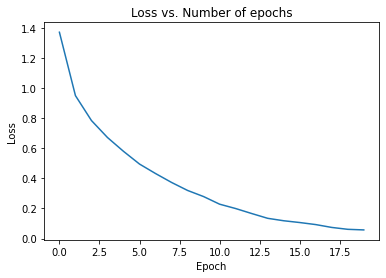

In [15]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Number of epochs');
plt.show

<function matplotlib.pyplot.show>

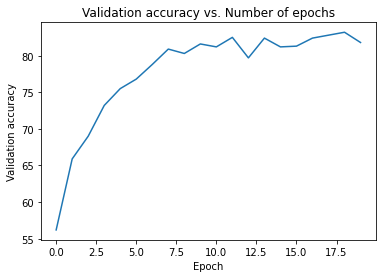

In [16]:
plt.plot(val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs. Number of epochs');
plt.show

In [17]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the network on the 1000 test images: 80.5 %
